# DSCI 100 Final Project 

## Analysis of player activity patterns by time of day on a Minecraft research server
*Kaitlyn Uy 34370213 for DSCI 100-103 2025S*

In [5]:
## Load in libraries (run this cell before contiuing)
library(tidyverse)
library(tidyr)
library(repr)
library(infer)
library(cowplot)
library(dplyr) 
library(purrr)
library(lubridate) 
library(janitor)
options(repr.matrix.max.rows = 6)

## Introduction 

Minecraft, developed by Mojang Studios and released in 2011, is a 3D sandbox video game in which players can freely explore, build, and interact with the virtual environment in a world composed of blocks and entities [1]. At the University of British Columbia, a research group in the Department Computer Science led by Frank Wood has created a Minecraft server to collect data on player behaviour.
Understanding player activity patterns is vital for effective server management. Since servers are often limited by their resources, the research team must be able to predict periods of high demand to ensure a smooth player experience. Using historical session data, this project aims to identify the times of day when player activity is at its highest.

### *Question: Can the **hour of day** predict the number of concurrent active players on the Minecraft research server, based on play session data?*

The question we aim to answer in this report is: *can the **hour of day** predict the number of concurrent active players on the Minecraft research server, based on play session data?* The response variable in this analysis is the number of concurrent active players, aggregated by hour. The primary explanatory variable we focus on is hour of day. Other potential variables for future research could include day of week (e.g. whether it is a weekend), month, or season. 

The dataset used in this analysis, **sessions.csv**, contains 1535 rows and 5 columns containing player session information on the Minecraft research server. Each row indicates a single play session with the following variables:

| Variable             | Type       | Description                                              |
|----------------------|------------|----------------------------------------------------------|
| `hashed_email`       | Character  | Anonymized player identifier                             |
| `start_time`         | String     | Human-readable session start time (in DD/MM/YYYY HH:MM)  |
| `end_time`           | String     | Human-readable session end time (in DD/MM/YYYY HH:MM)    |
| `original_start_time`| Numeric    | UNIX Epoch time in milliseconds (raw server timestamp)   |
| `original_end_time`  | Numeric    | UNIX Epoch time in milliseconds (raw server timestamp)   |


The dataset, collected via server logs, spans several months of server activity, with session lengths varying from a few minutes to multiple hours. As player data is anonymized, this dataset may be limited to a certain demographic, thus misrepresenting the target population. Furthermore, overlapping sessions, or those that cross hourly or daily boundaries require careful analysis in order to produce accurate player counts.


## Methods and results 

First, start by downloading the data and reading it in. It has variables that are not necessary, so we will take them out. The columns that we want to focus on are `start_time` and `end_time`. We will convert the strings into datetime objects and extract time-of-day features from them. The `original_start_time` and `original_end_time` columns could be used in future work for more precision. 

In [7]:
## Read in the data and show the start of the table
sessions_df <- read_csv("data/sessions.csv") 

## Create a new column, `duration`, by converting strings and calculating the total time between start and end time
sessions <- sessions_df |> 
    clean_names() |> 
    select(start_time:end_time) |> 
    mutate(start_time = dmy_hm(start_time),
    end_time = dmy_hm(end_time), 
    duration = as.numeric(difftime(end_time, start_time, units = "mins")))
head(sessions)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


start_time,end_time,duration
<dttm>,<dttm>,<dbl>
2024-06-30 18:12:00,2024-06-30 18:24:00,12
2024-06-17 23:33:00,2024-06-17 23:46:00,13
2024-07-25 17:34:00,2024-07-25 17:57:00,23
2024-07-25 03:22:00,2024-07-25 03:58:00,36
2024-05-25 16:01:00,2024-05-25 16:12:00,11
2024-06-23 15:08:00,2024-06-23 17:10:00,122


We will make visualizations of each hour and then plot the average across all days in order to find the average player count per hour. This visualization is used to identify the peak times on the server, ie. the hours with the maximum number of players. 

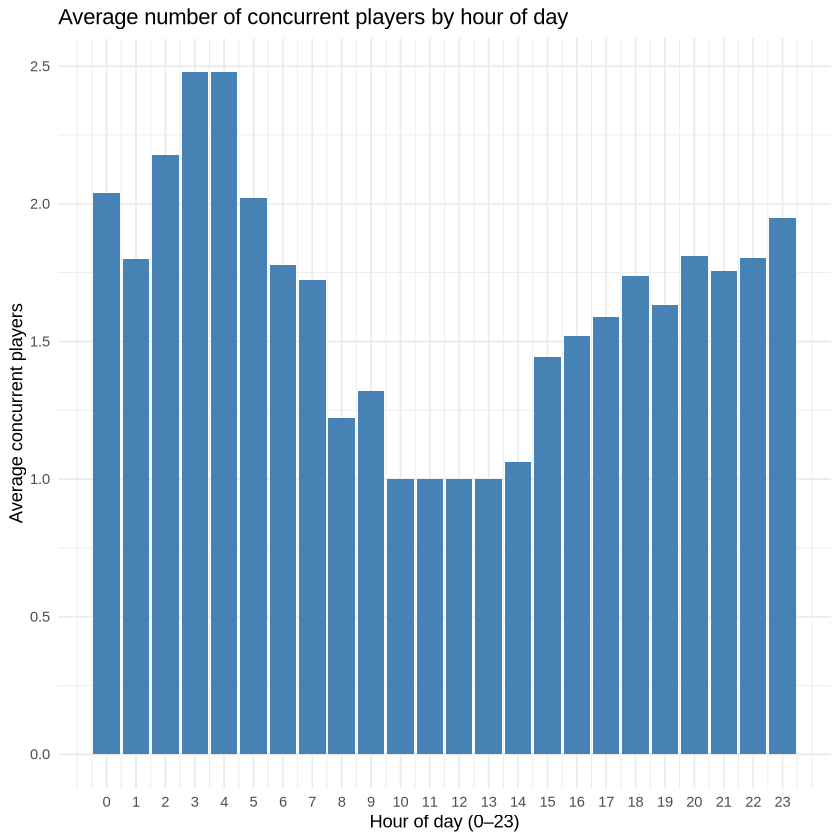

In [14]:
## Make visualizations of each hour 
sessions_clean <- sessions |> 
  filter(!is.na(start_time), !is.na(end_time), end_time >= start_time) 
# Cleaning session data by removing sessions with missing start or end times, 
# or where end time is earlier than the start time 

expanded_sessions <- sessions_clean |> 
  rowwise() |>                           
  mutate(hours = list(seq(floor_date(start_time, "hour"), ceiling_date(end_time, "hour") - hours(1), by = "hour"))) |> 
  unnest(hours)
# head(expanded_sessions)

## Create hour-of-day variable
expanded_sessions <- expanded_sessions |>
    mutate(hour_of_day = hour(hours))

## Count number of players per hour per day
hourly_counts <- expanded_sessions |> 
    count(date = as_date(hours), hour_of_day)

## Average across all days
hourly_summary <- hourly_counts |> 
    group_by(hour_of_day) |> 
    summarise(avg_players = mean(n), .groups = "drop")

## Plot average players 
average_plot <- ggplot(hourly_summary, aes(x = hour_of_day, y = avg_players)) +
    geom_col(fill = "steelblue") +
    scale_x_continuous(breaks = 0:23) +
    labs(
        title = "Average number of concurrent players by hour of day", x = "Hour of day (0–23)", y = "Average concurrent players") +
  theme_minimal()
average_plot

For the busiest hours, we will generate bootstrap samples by resampling the given data with replacement and then calculate bootstrap distributions of mean player counts in order to get a confidence interval for our estimate and to understand variability in peak player counts. In this case, we use bootstrapping since we are estimating mean concurrent players per hour- using cross-validation would be unnecessary as it doesn't involve the use of classification or regression. 

To bootstrap, we assume that the data is a representative sample and that sessions span range of dates and hours for natural variability. We treat each row as an independent unit that can be resampled, and we are estimating a statistic - mean/median number of concurrent players per hour, so the sample size is large enough for the bootstrap distribution to estimate the true sampling distribution. However, the dataset may not be fully random, player sessions may not be independent since the same user can play multiple times, and the dataset may also not be perfectly representative. Moreover, bootstrapping only involves uncertainty estimates, and in this report, we only focus on a single variable- hour of day. The results we obtain may not be nuanced enough for real-world applications. 

In [18]:
## Create variable for hours of interest 
hours_of_interest <- c(0, 2, 3, 4, 23)

## Filter for those hours and count players 
busy_hour_counts <- expanded_sessions |>
  filter(hour_of_day %in% hours_of_interest) |>
  count(date = as_date(hours), hour_of_day)

## Bootstrap: Sample from full dataset (not per group size), setting seed for reproducibility 
set.seed(123)

bootstrap_results <- busy_hour_counts |>
  group_by(hour_of_day) |>
  rep_sample_n(size = nrow(sessions), reps = 1000, replace = TRUE) |>
  group_by(hour_of_day, replicate) |>
  summarise(mean_players = mean(n), .groups = "drop")
# bootstrap_results 

## Calculate 95% confidence intervals to estimate the range of concurrent players for the busiest hours. 
bootstrap_summary <- bootstrap_results |>
  group_by(hour_of_day) |>
  summarise(
    lower_ci = quantile(mean_players, 0.025), # for lower quantile 
    upper_ci = quantile(mean_players, 0.975), # for upper quantile 
    mean_boot = mean(mean_players),
    .groups = "drop")

## Show result
bootstrap_summary

busy_hour_counts |> count(hour_of_day)

hour_of_day,lower_ci,upper_ci,mean_boot
<int>,<dbl>,<dbl>,<dbl>
0,1.915824,2.158074,2.034726
2,2.034273,2.333416,2.175553
3,2.299636,2.649274,2.475649
4,2.317593,2.655171,2.482384
23,1.792189,2.123188,1.949040


hour_of_day,n
<int>,<int>
0,106
2,108
3,109
4,111
23,100


PROJECT PATH: 

1. load and clean data using sessions.csv, focus on timestamps and user IDs → *code cells will download a dataset, reproducibly and sensibly wrangle and clean* 
    1. calculate session lengths (convert strings into date, then mutate to create new column ‘duration’ through end_time - start_time 
    2. calculate mean concurrent players per hour, for each hour → identify the top busies hours and then resample the relevant session data (with replacement and calculate bootstrap mean of number of players, iterate, then use quantile() to get 95% CI) 
2. create hourly/daily counts → *summarize and visualize the data* 
    1. add short section summarizing number of sessions per day, range of session lengths, brief comment on general shape of traffic over time - probably good to put one large histogram showing total player count per hour across all days → for summary (main results section) 
3. plot traffic by hour/day and find peak windows → *appropriately answer a predictive question* 
    1. histogram of player count per hour of the day (0-23), can bootstrap mean counts per hour 
        1. apply statistical model- bootstrap confidence intervals **for the busiest hours only** to understand variability in peak player counts 
4. use markdown to narrate analysis and communicate question asked- assumptions and limitations 
    1. why bootstrapping is appropriate → summarizing average hourly traffic, can give confidence intervals on averages without making strong assumptions, since we’re estimating means/medians and their uncertainty- we can make the assumption that this dataset is a single sample from a greater population and that based on the CIs that we get from this analysis, we can use it to predict how a larger population would behave (representative sample); bootstrapping resamples data directly and lets us estimate uncertainty without relying on assumptions about distribution
    2. estimating mean concurrent players per hour -> choose bootstrapping since we aren't clustering or trying to predict a new category; no complex model assumptions. therefore, using cross-validation is unnecessary. 
        1. key assumptions of bootstrapping: we must assume that the data is a representative sample - sessions span range of dates and hours for natural variability. We will treat each row as an independent unit that can be resampled, and we are estimating a statistic - mean/median number of concurrent players per hour, so the sample size is large enough for the bootstrap distribution to estimate the true sampling distribution
        2. limitations: dataset isn’t from random sampling/sessions may not be independent since the same user can play multiple times, dataset may also not be perfectly representative; bootstrapping doesn't perfectly portray future trends, only uncertainty estimates; also only focusing on hour of day, so results may not be nuanced enough
        4. used 95% CI to estimate the range of average concurrent players for the busiest hours 
5. submit as .pdf which includes a link to github repo and an .ipynb file that is fully reproducible and runs from top to bottom without additional files

## Discussion

- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

## References

[1] https://minecraft.fandom.com/wiki/Minecraft_Wiki